This notebook provides a short sample on how to evaluate your trained model. We will continue from our previous notebook `03_` which has trained a working model. 

The complete evaluation script can be found in the root directory of the repository `eval_direct.py`

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import yaml
import numpy as np
import pandas as pd
from collections import defaultdict
from pathlib import Path
from tqdm import tqdm
import pickle
import torch
from torch.utils.data import DataLoader, TensorDataset
import lightning.pytorch as pl
from lightning.pytorch import loggers as pl_loggers
from lightning.pytorch.callbacks import ModelCheckpoint
pl.seed_everything(42)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid', {'axes.grid' : False})
sns.set_theme(context='paper')


# Adjusting global plotting parameters
plt.rcParams['font.size'] = 16        # Adjusts the main font size
plt.rcParams['axes.labelsize'] = 16   # Font size of x and y labels
plt.rcParams['xtick.labelsize'] = 16  # Font size of numbers on x-axis
plt.rcParams['ytick.labelsize'] = 16  # Font size of numbers on y-axis
plt.rcParams['legend.fontsize'] = 16  # Font size of legend

import sys
sys.path.append('..')

from chaosbench import dataset, config, utils, criterion
from chaosbench.models import model, mlp, cnn, ae

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The history saving thread hit an unexpected error (OperationalError('no such table: history')).History will not be written to the database.


[rank: 0] Global seed set to 42
/burg/home/jn2808/.conda/envs/bench/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Prediction Visualization

For ClimaX...

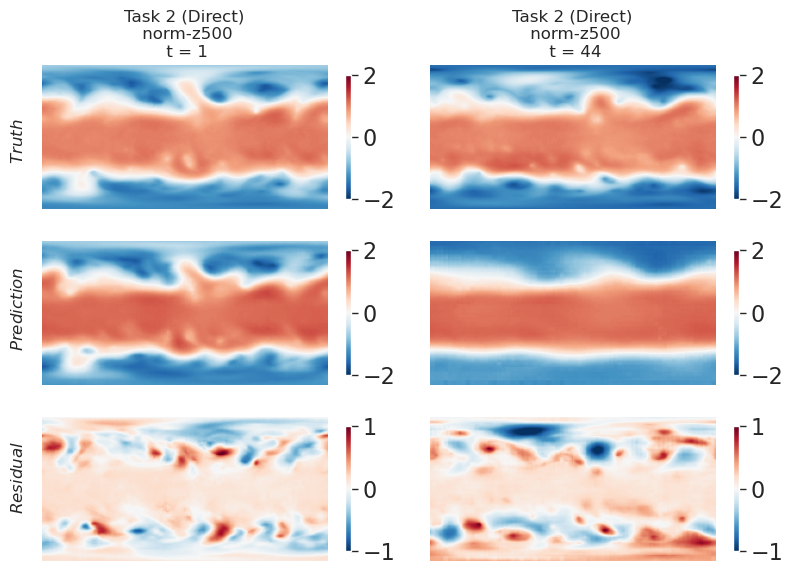

In [49]:
#################### CHANGE THIS ####################
date_idx = 0
param = 'z'
level = 500
model_name = 'climax'
task_num = 2

plot_idx = [1, config.N_STEPS - 1]
######################################################

all_preds = list()
all_truth = list()

## Dataset: Prediction
### List filenames related to the model and task number

log_dir = Path('../logs') / model_name
preds_filepath = log_dir / 'preds' / f'task{task_num}'
preds_files = list(preds_filepath.glob('*.pkl'))
preds_files.sort()

### Load the actual predictions (only for t = 1, and t = 44)
for file_path in np.array(preds_files)[[0, -1]]:
    with open(file_path, 'rb') as file:
        data = pickle.load(file)
        data = data['pred'][f'{param}_{level}']
        all_preds.append(data[date_idx])

## Dataset: Label
output_dataset = dataset.S2SObsDataset(years=[2022], n_step=config.N_STEPS)
_, output_x, output_y = output_dataset[date_idx]

for idx in plot_idx:
    all_truth.append(output_y[idx][config.PARAMS.index(param), config.PRESSURE_LEVELS.index(level)].detach().cpu().numpy())


# Plotting
all_truth = np.array(all_truth)
all_preds = np.array(all_preds)
all_preds = (all_preds - all_preds.mean()) / all_preds.std()

f, ax = plt.subplots(3, len(plot_idx), figsize=(8, 3 * len(plot_idx)))

for time_idx in range(len(plot_idx)):

    im0 = ax[0, time_idx].imshow(all_truth[time_idx], cmap='RdBu_r', vmin=-2, vmax=2)
    # ax[0, time_idx].set_title(f'Truth\n(step={plot_idx[time_idx]})')
    ax[0, time_idx].axis('off')
    cbar0 = f.colorbar(im0, ax=ax[0, time_idx], shrink=0.8)

    im1 = ax[1, time_idx].imshow(all_preds[time_idx], cmap='RdBu_r', vmin=-2, vmax=2)
    # ax[1, time_idx].set_title(f'Prediction\n(step={plot_idx[time_idx]})')
    ax[1, time_idx].axis('off')
    cbar1 = f.colorbar(im1, ax=ax[1, time_idx], shrink=0.8)

    im2 = ax[2, time_idx].imshow(all_preds[time_idx] - all_truth[time_idx], cmap='RdBu_r', vmin=-1, vmax=1)
    # ax[2, time_idx].set_title(f'Residual\n(step={plot_idx[time_idx]})')
    ax[2, time_idx].axis('off')
    cbar2 = f.colorbar(im2, ax=ax[2, time_idx], shrink=0.8)

# Adding titles for each row
titles = [r'$Truth$', r'$Prediction$', r'$Residual$']
for idx, title in enumerate(titles):
    f.text(-0.01, 0.75 - idx*0.28, title, va='center', ha='left', fontsize=12, rotation=90)

ax[0,0].set_title(f'Task {task_num} (Direct)\n norm-{param}{level}\n t = 1', fontsize=12)
ax[0,1].set_title(f'Task {task_num} (Direct)\n norm-{param}{level}\n t = 44', fontsize=12)
plt.tight_layout()
plt.show()
f.savefig(f'../docs/preds_{model_name}_{param}{level}_direct_Task {task_num}.pdf', dpi=200, bbox_inches='tight');


## Power Spectrum

NameError: name 'model_list' is not defined

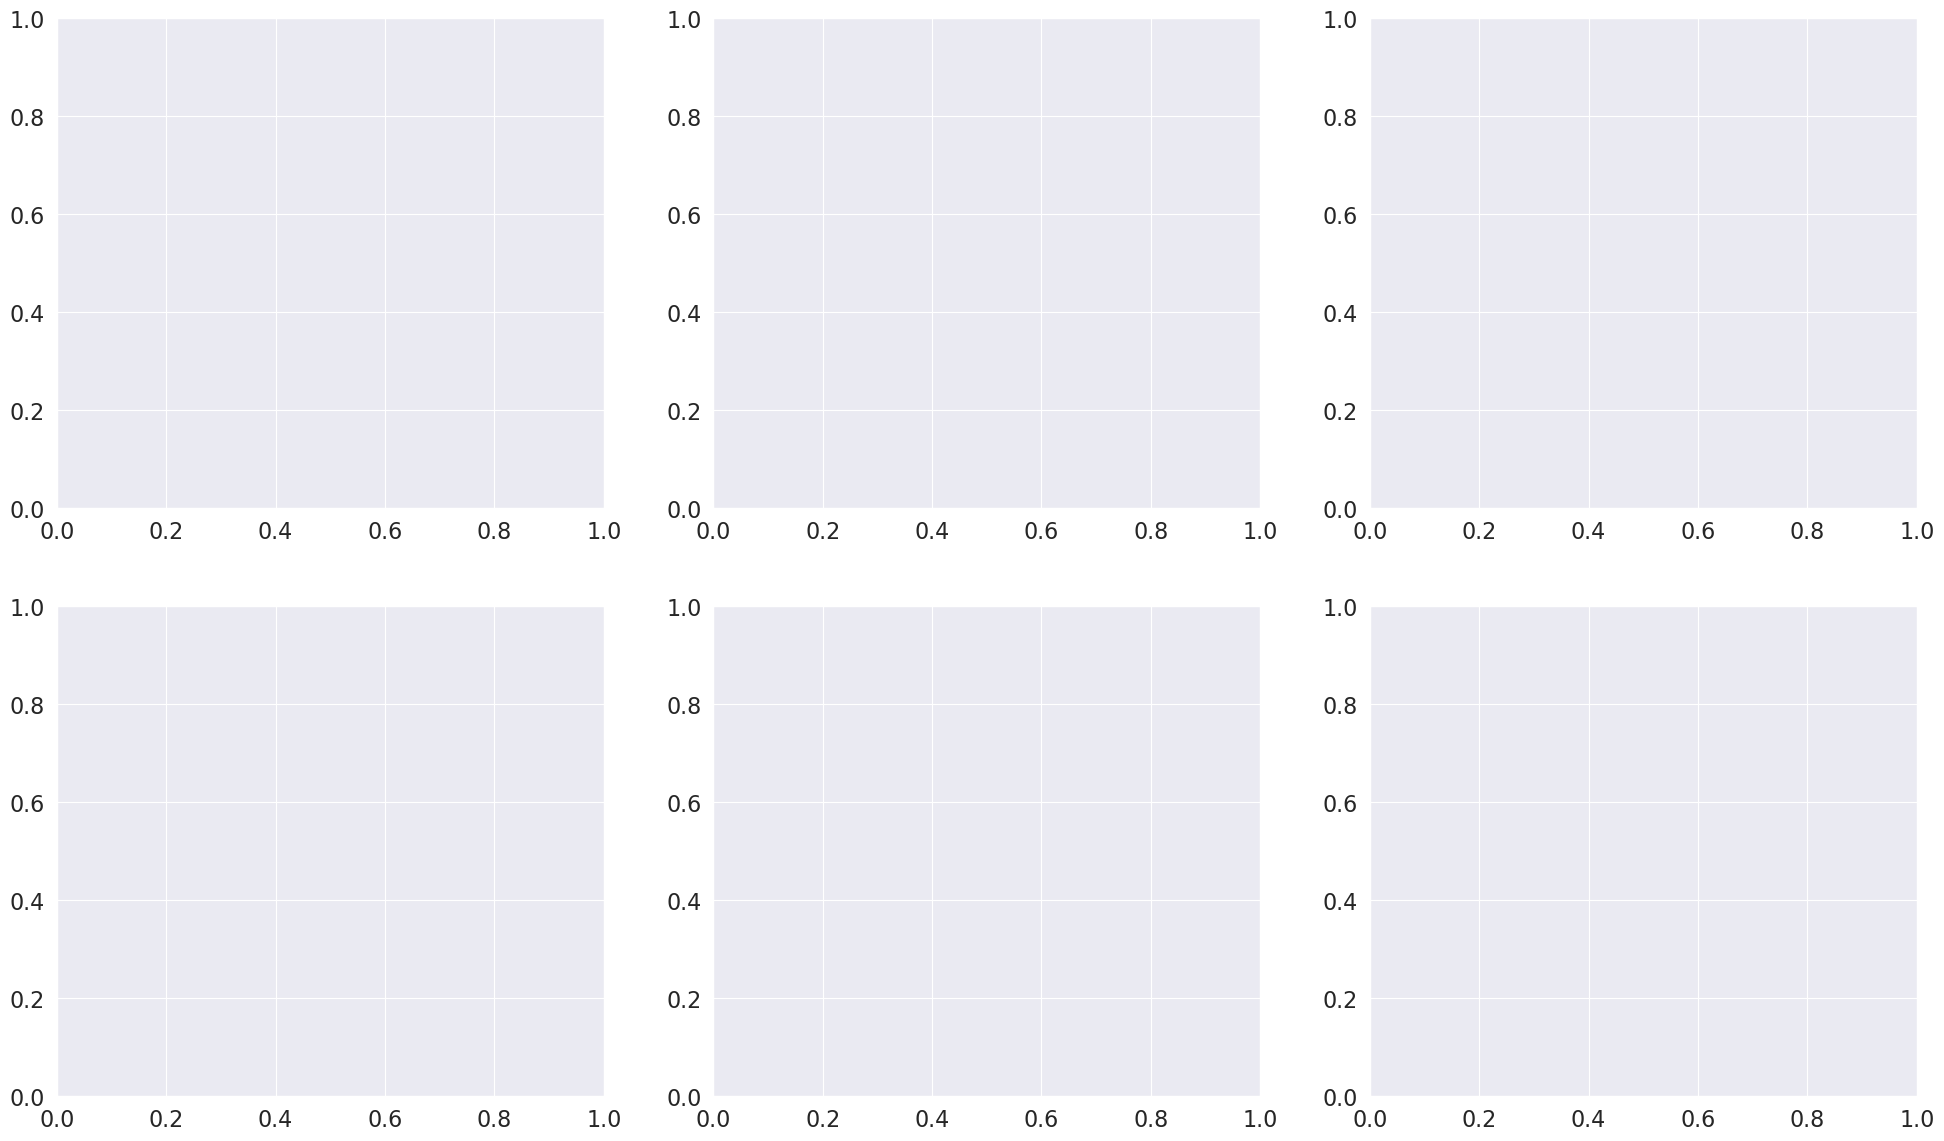

In [50]:
#################### CHANGE THIS ####################
date_idx = 0
n_steps = [0, 43]
model_type = 'climax'
task = 2
######################################################

param_levels = [['t', 850], ['z', 500], ['q', 700]]
all_Ek = dict()

## Initialize dataset
output_dataset = dataset.S2SObsDataset(years=[2022], n_step=config.N_STEPS)

## For plotting
f, ax = plt.subplots(len(n_steps), len(param_levels), figsize=(8*len(param_levels), 7*len(n_steps)))

for param_level_idx, param_level in enumerate(param_levels):
    param = param_level[0]
    level = param_level[1]

    print(f'Processing {model_name}')

    all_preds = list()
    all_truth = list()

    ## Dataset: Prediction
    ### List filenames related to the model and task number

    log_dir = Path('../logs') / model_name
    preds_filepath = log_dir / 'preds' / f'task{task_num}'
    preds_files = list(preds_filepath.glob('*.pkl'))
    preds_files.sort()

    ### Load the actual predictions (only for t = 1, and t = 44)
    for file_path in np.array(preds_files)[n_steps]:
        with open(file_path, 'rb') as file:
            data = pickle.load(file)
            data = data['pred'][f'{param}_{level}']
            all_preds.append(data[date_idx])

    ## Dataset: Label
    output_dataset = dataset.S2SObsDataset(years=[2022], n_step=config.N_STEPS)
    _, output_x, output_y = output_dataset[date_idx]

    for idx in plot_idx:
        all_truth.append(output_y[idx][config.PARAMS.index(param), config.PRESSURE_LEVELS.index(level)].detach().cpu().numpy())

    ## Post-process truth and predictions (have to normalize this since it comes in real values)
    all_truth = np.array(all_truth)
    all_preds = np.array(all_preds)
    all_preds = (all_preds - all_preds.mean()) / all_preds.std()

    # Plot power spectrum
    curr_pred_Ek, curr_truth_Ek = list(), list()

    for step_idx in range(all_preds.shape[0]):
        pred_t, truth_t = all_preds[step_idx], all_truth[step_idx]
        pred_power_t, truth_power_t = np.fft.fft2(pred_t), np.fft.fft2(truth_t)
        pred_power_t, truth_power_t = np.abs(pred_power_t)**2, np.abs(truth_power_t)**2

        ny, nx = pred_t.shape
        kx = np.fft.fftfreq(nx) * nx
        ky = np.fft.fftfreq(ny) * ny

        kx, ky = np.meshgrid(kx, ky)
        k = np.sqrt(kx**2 + ky**2)

        k_bins = np.arange(0.5, np.max(k), 1)
        k_bin_centers = 0.5 * (k_bins[:-1] + k_bins[1:])
        pred_Ek = np.histogram(k, bins=k_bins, weights=pred_power_t)[0] / np.histogram(k, bins=k_bins)[0]
        truth_Ek = np.histogram(k, bins=k_bins, weights=truth_power_t)[0] / np.histogram(k, bins=k_bins)[0]

        curr_pred_Ek.append(pred_Ek)
        curr_truth_Ek.append(truth_Ek)

        if step_idx in n_steps:
            step_num = n_steps.index(step_idx)
            ax[step_num, param_level_idx].set_title(f'{param}-{level}', fontsize=16)
            ax[step_num, param_level_idx].loglog(pred_Ek, label=f'{model_spec}', linewidth=3)
            ax[step_num, param_level_idx].set_xlabel('Wavenumber, k')
            ax[step_num, param_level_idx].set_ylabel(f'Power, S(k); {step_idx + 1}-day ahead')
            ax[step_num, param_level_idx].set_ylim([10**0, 10**7])
            ax[step_num, param_level_idx].legend()

    all_Ek[f'{model_spec}:{param}-{level}'] = np.array(curr_pred_Ek)
    all_Ek['truth'] = np.array(curr_truth_Ek)
                
plt.show()
# f.savefig(f'../docs/specdiv_{model_type}_Task {task}.pdf', dpi=200, bbox_inches='tight');